<a href="https://colab.research.google.com/github/Joriswillems/deeplearning/blob/master/assignment3/Assignment_3_2_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Question 2

<b>Group 82</b>
* <b> Student 1 </b> : Joris Willems + 0908753
* <b> Student 2 </b> : Lars Schilders + 0908729

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from keras import Model
from keras.models import load_model 
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from keras import losses, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping


# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [2]:
from google.colab import drive

if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [3]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
base_path = './'
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

--2020-06-12 12:58:19--  https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404025595 (385M) [application/octet-stream]
Saving to: ‘Flickr8k_processed.pkl’

Flickr8k_processed. 100%[===================>] 385.31M  6.67MB/s    in 60s     

2020-06-12 12:59:20 (6.47 MB/s) - ‘Flickr8k_processed.pkl’ saved [404025595/404025595]

Elapsed time: 64.17261219024658 seconds.
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [7]:
from keras.models import Model

def norm_gen(images, batch_size=200):
    i = 0
    while True:
        yield (images[i:batch_size + i] / 255 * 2 - 1)#.astype(np.float32)
        i += batch_size

def get_image_codes(images, batch_size):      
    convnet = MobileNetV2(input_shape=(128,128,3), 
                            include_top=False, 
                            weights='imagenet')
    #convnet.summary()


    model = Model(inputs = convnet.input, outputs=convnet.get_layer("Conv_1").output)
    image_codes = model.predict(norm_gen(images, batch_size), steps=len(images)/batch_size)
    image_codes = image_codes.reshape(8091,20480).astype(np.float32)
    return image_codes

image_codes = get_image_codes(images, 200)
print(image_codes.shape)

9412608/9406464 [==============================] - 2s 0us/step
(8091, 20480)


# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [0]:
# ...

# retrieve max caption length
caption_lengths = [len(x) for cap in captions for x in cap ]
max_caption_length = np.max(caption_lengths)


# flatten all words
words = np.array([word for caps in captions for cap in caps for word in cap])

# count words and make dictionary 
word_dict = dict(zip(*np.unique(words, return_counts=True)))
#add stop words and associated counts to dictionary 
word_dict['_'] = 5 * len(captions) - caption_lengths.count(1)

# sort by count frequency
sorted_idcs = np.flip(np.argsort(list(word_dict.values())))
sorted_words = np.array(list(word_dict.keys()))[sorted_idcs]
sorted_words[[0,1]] = sorted_words[[1,0]]
word_to_idx = dict(zip(sorted_words, np.arange(len(sorted_words))))

# invert word_to_idx
idx_to_word = {v: k for k,v in word_to_idx.items()}
num_words = len(word_dict)

#some checks
assert word_to_idx['_'] == 0
assert word_to_idx['a'] == 1
# ...

There is some bias in the dataset in the sense that there are apparently a lot of images with dogs and men in it.

In [9]:
print("Maximum caption length (not including _ at the end): {}".format(max_caption_length))
print("Number of unique words: {}".format(num_words))


Maximum caption length (not including _ at the end): 35
Number of unique words: 2992


# Train/Validation/Test Split

In [0]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [11]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


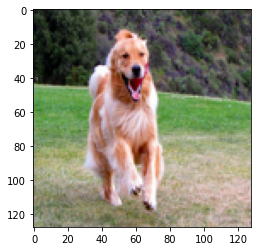

['a', 'dog', 'running', 'outside', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





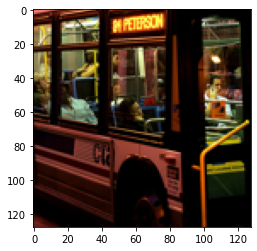

['a', 'bus', 'filled', 'with', 'passengers', 'in', 'at', 'night', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [12]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [0]:
from keras.layers import Lambda

In [15]:
print("Neural Code length: {}".format(train_codes.shape[1]))
print("max caption length: {}".format(max_caption_length))
print("Embedding dim: {}".format(embedding_dim))
print("Number of words: {}".format(num_words))

Neural Code length: 20480
max caption length: 35
Embedding dim: 512
Number of words: 2992


In [0]:
from keras.layers import Lambda

def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

    # inputs
    image_input = Input(shape=(code_length,))               #(None, 512)
    caption_input = Input(shape=(max_caption_length - 1,))  #(None, 34)

    # Embed image from 20480 to 512 dim
    image_emb = Dense(embedding_dim, name="image_embedding")(image_input)   #(None, 512)

    # Expand dimension for concatenating image and caption
    image_emb = Lambda(lambda x: K.expand_dims(x, axis=1), name="expand")(image_emb) #(None, 1, 512)

    # Embed captions to 512 dim
    caption_emb = Embedding(max_caption_length-1, embedding_dim, name="word_embedding")(caption_input)  #(None, 34, 512)

    # Concatenate image and caption
    concat_emb = concatenate([image_emb, caption_emb], axis=1)   #(None, 35, 512)

    # Process data with LSTM
    lstm_output = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=True, name="lstm")(concat_emb)  #(None, 35, 512)

    # Map to categorical distribition (via Softmax) of length num_words
    output = Dense(num_words, activation='softmax', name="softmax")(lstm_output)  #(None, 35, 2992)

    # Return model
    return Model([image_input, caption_input], output)



model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

How does the input and output need to be organized? For how many time steps T should the LSTM be unrolled? For each time step, $t = 0, . . . , T − 1$, which embedding should be input to the LSTM and what should be the target?

ANSWER: 

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [31]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

# ...
model.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(x=[train_codes, train_y[:,:-1]], 
          y=np.expand_dims(train_y, axis=-1),
          batch_size=100, 
          epochs=1,
          callbacks=[early_stopping_callback],
          validation_data=([val_codes, val_y[:,:-1]], np.expand_dims(val_y,axis=-1)))
# ...

model.save(os.path.join(base_path, 'model.h5'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30455 samples, validate on 5000 samples
Epoch 1/1
11100/30455 [=========>....................] - ETA: 19s - loss: 2.0387 - sparse_categorical_accuracy: 0.7170

KeyboardInterrupt: ignored

## Report which data serves as input and which serves as output, and why.

#### ANSWER: 

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [0]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()

# ...
train_loss, train_acc = model.evaluate([train_codes, train_y[:,:-1]], np.expand_dims(train_y,axis=-1))
val_loss, val_acc = model.evaluate([val_codes, val_y[:,:-1]], np.expand_dims(val_y,axis=-1))

print("Train loss: {:.3f}".format(train_loss))
print("Validation loss: {:.3f}".format(val_loss))
# ...

5000/5000 [==============================] - 5s 1ms/step
Train loss: 0.822
Validation loss: 1.111


# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [0]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
    
    # neural code of image 
    image_input = Input(shape=(code_length,))  #(None, 20480)

    # Create list for storing all probabilities of 35 caption words
    caption = []

    # Define all required layers
    image_emb_layer = Dense(embedding_dim, name="image_embedding")
    expand_layer = Lambda(lambda x: K.expand_dims(x, axis=1), name="expand")
    lstm_layer = LSTM(lstm_dim, dropout=lstm_dropout, return_state=True, name="lstm")
    softmax_layer = Dense(num_words, activation='softmax', name='softmax')
    prob_to_word_layer = Lambda(lambda x: K.argmax(x, axis=-1), name="prob_to_word")
    word_emb_layer = Embedding(max_caption_length-1, embedding_dim, name="word_embedding")

    # Embed image from 20480 to 512 dim
    image_emb = image_emb_layer(image_input)   #(None, 512)

    # Add dimension such that this neural code is treated as a length-1 sequence
    image_emb = expand_layer(image_emb)        #(None, 1, 512)

    # Pass image sequence to LSTM layer
    lstm_out,  h_state,  c_state = lstm_layer(image_emb)  #(None, 500),  (None, 500)

    # Map to categorical distribition (via Softmax) of length num_words (and add result to list)
    word_prob = softmax_layer(lstm_out)      #(None, 2992)
    caption.append(word_prob)

    # Choose word with highest probability (and add result to list)
    caption_word = prob_to_word_layer(word_prob)  #(None, 1)

    # Unroll model, output of step t-1 is input of LSTM in step t 
    for t in range(1, max_caption_length):

        # Embed last predicted word to 512 dim embedding
        caption_word_embedding = word_emb_layer(caption_word) #(None, 512)

        # Add dimension such that this neural code is treated as a length-1 sequence
        caption_word_embedding_exp = expand_layer(caption_word_embedding)

        # Pass previously prediction word sequence to LSTM layer
        lstm_out, h_state, c_state = lstm_layer(caption_word_embedding_exp, initial_state=[h_state, c_state]) #(None, 500),  (None, 500)
        
        # Map to categorical distribition (via Softmax) of length num_words (and add result to list)
        word_prob = softmax_layer(lstm_out)
        caption.append(word_prob)

        # Choose word with highest probability (and add result to list)
        caption_word = prob_to_word_layer(word_prob)  #(None, 1)

    # Stack all word probabilities 
    output = Lambda(lambda x: K.stack(x, axis=1))(caption)

    model = Model(inputs=[image_input], outputs=output)

    for lay_name, w in weights.items():
        model.get_layer(lay_name).set_weights(w)

    return model

# Get the weights from trained model, and put them in a list 'weights'.
# ...
transfer_layer_names = ["image_embedding", "lstm", "softmax", "word_embedding"]
weights = {}

for lay_name in transfer_layer_names:
    weights[lay_name] = model.get_layer(lay_name).get_weights()

# ...

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [0]:
decoder.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [39]:
decoder.predict(test_codes, batch_size=10).shape

(1000, 35, 2992)

In [0]:
# ...

# ...